In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau,LearningRateScheduler
import matplotlib.pyplot as plt

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=12000)])
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
import loss_2D, datagenerator_2p5D, Model_2D_UNet_RCAN

data_generator = datagenerator_2p5D.data_generator
make_generator = Model_2D_UNet_RCAN.make_generator
generator_loss = loss_2D.generator_loss

In [11]:
patch_size = 256
n_patches =  8
channel_n =  0
batch_size = 1


augment = False
shuffle = True
add_noise= True
l_poisson1 = 0.1
l_poisson2= 1.0


threshold = 0.2
ratio = 1.0

GT_image_dr = r'D:\Projects\MSD_UNet_RCAN\GT\STED\train\STED.tif'
wf_image_dr =r'D:\Projects\MSD_UNet_RCAN\GT\STED\train\Confocal.tif'
lowSNR_image_dr =r'D:\Projects\MSD_UNet_RCAN\GT\Confocal\train\Average.tif'


x_train,w_train, y_train,_,_,_ = data_generator(GT_image_dr, lowSNR_image_dr,wf_image_dr, patch_size, n_patches,
                                                n_channel=channel_n, threshold = threshold,ratio=1.0,lp1=l_poisson1,lp2=l_poisson2,
                                                augment=augment, shuffle=shuffle,
                                                add_noise=add_noise)

(13, 2, 2048, 2048)
650
The training set shape is: (650, 256, 256, 1)
The validation set shape is: (0, 256, 256, 1)


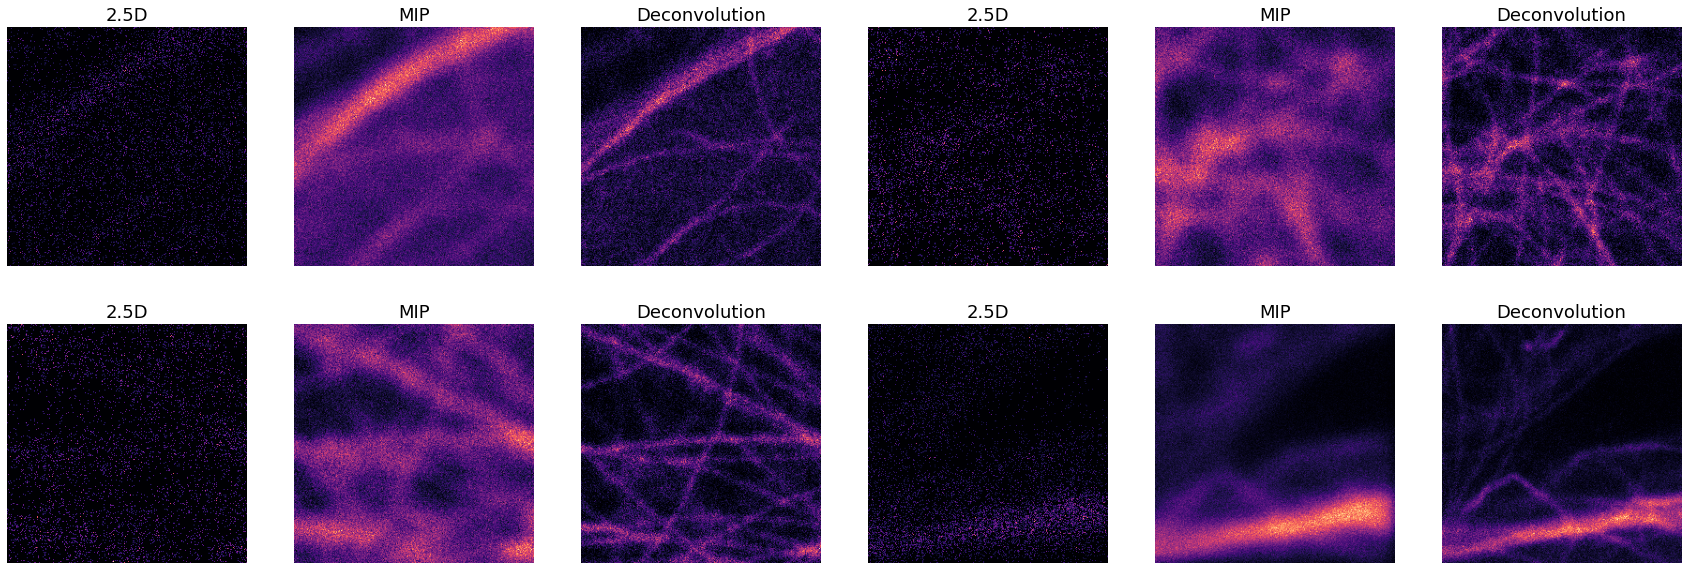

In [12]:
ix = np.random.randint(0,len(x_train),4)
fig = plt.figure(figsize=(30,10))

for i in range(4):
    fig.add_subplot(2,6, 3*i+1)
    cmap=plt.get_cmap('magma')
    plt.imshow(x_train[ix[i],:,:,0].squeeze(),cmap)
    plt.title('2.5D',fontdict={'fontsize':18})
    plt_axis = plt.axis('off')
    
    fig.add_subplot(2,6, 3*i+2)
    cmap=plt.get_cmap('magma')
    plt.imshow(w_train[ix[i],:,:,0].squeeze(),cmap)
    plt.title('MIP',fontdict={'fontsize':18})
    plt_axis = plt.axis('off')
    
    fig.add_subplot(2,6, 3*i+3)
    cmap=plt.get_cmap('magma')
    plt.imshow(y_train[ix[i],:,:,0].squeeze(),cmap)
    plt.title('Deconvolution',fontdict={'fontsize':18})
    plt_axis = plt.axis('off')

In [13]:
filters =[32,64,128]

num_filters = 64
r = 16
filters_cab=num_filters/r
num_RG=5
num_RCAB=5

gen_lr = 1e-4


generator_input = Input((patch_size, patch_size,1))
generator = make_generator(generator_input, filters, num_filters,filters_cab,num_RG,num_RCAB,
                           kernel_shape=3,dropout=0.2)

In [14]:
# This cell is for finding an optimal initial value for learning rate.
#You can skip this if you already pre-set the learning rat above.


# M = int(np.floor(len(x_train)/5))
# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-8)
# lr_schedule = LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
# generator.compile(optimizer=optimizer, loss=generator_loss)
# results = generator.fit(x=x_train[0:M],y=[w_train[0:M],y_train[0:M]], batch_size=batch_size, epochs=100,verbose=1,
#                         callbacks=lr_schedule,validation_split=0.1)
# val_loss = np.asarray(results.history["val_loss"])
# lr = np.asarray(results.history["lr"])
# gen_lr = lr[np.nanargmin(val_loss)]

In [15]:
model_save_directory = r"D:\Projects\MSD_UNet_RCAN\GT\Confocal\confocal_2step.h5" 
n_epochs =  100

gen_opt = keras.optimizers.Adam(learning_rate=gen_lr)
generator.compile(optimizer=gen_opt, loss={'UNet':generator_loss,'RCAN':generator_loss},loss_weights=[1,1])
callbacks = [
    EarlyStopping(patience=50, verbose=1),
    ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=5),
    ModelCheckpoint(filepath=model_save_directory, verbose=1, save_best_only=True, save_weights_only=True)]

In [ ]:
results = generator.fit(x=x_train,y={'UNet':w_train,'RCAN':y_train}, batch_size=batch_size, epochs=n_epochs,verbose=1,
                        callbacks=callbacks,validation_split=0.1)

Epoch 1/100
585/585 [==============================] - ETA: 0s - loss: 0.1292 - conv2d_144_loss: 0.0687 - conv2d_36_loss: 0.0605
Epoch 00001: val_loss improved from inf to 0.11861, saving model to D:\Projects\MSD_UNet_RCAN\GT\Confocal\confocal_2step.h5
585/585 [==============================] - 79s 122ms/step - loss: 0.1292 - conv2d_144_loss: 0.0687 - conv2d_36_loss: 0.0605 - val_loss: 0.1186 - val_conv2d_144_loss: 0.0675 - val_conv2d_36_loss: 0.0511 - lr: 1.0000e-04
Epoch 2/100
585/585 [==============================] - ETA: 0s - loss: 0.1165 - conv2d_144_loss: 0.0666 - conv2d_36_loss: 0.0500
Epoch 00002: val_loss did not improve from 0.11861
585/585 [==============================] - 76s 130ms/step - loss: 0.1165 - conv2d_144_loss: 0.0666 - conv2d_36_loss: 0.0500 - val_loss: 0.1200 - val_conv2d_144_loss: 0.0684 - val_conv2d_36_loss: 0.0516 - lr: 1.0000e-04
Epoch 3/100
585/585 [==============================] - ETA: 0s - loss: 0.1158 - conv2d_144_loss: 0.0662 - conv2d_36_loss: 0.0497
